In [51]:
import networkx as nx
import numpy as np
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import copy
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Generalized Threshold Mode

In [94]:
class general_threshold():
    def __init__(self):
        self.g = nx.DiGraph()
    
    def fit(self, g):
        # fit graph with probability
        in_degree = g.in_degree()
        centrality = nx.degree_centrality(g)
        # init influence
        for e in g.edges():
            if(in_degree[e[1]] >= 10):
                g[e[0]][e[1]]['influence'] = 1 / int(np.log(in_degree[e[1]]))
            else:
                g[e[0]][e[1]]['influence'] = 1 
        # init threshold. In GT model, the threshold of each node is assigned half of it's centrality
        for n in g.nodes():
            g.nodes[n]['threshold'] = centrality[n]/4
        
        self.g = g
        return g
    
    # diffusion to all possible nodes
    def diffusion_all(self, init_seed):
        final_activated = copy.deepcopy(init_seed)
        activated = []
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(final_activated)]
        while True:
            flag = False
            for v in self.g.nodes():
                if v in final_activated:
                    continue
                # get the activated neighbor nodes of current node
                activated_u = list(set(self.g.predecessors(v)).intersection(set(final_activated)))
                total_threshold = 0.0
                for u in activated_u:
                    total_threshold += self.g[u][v]['influence']
                # if total_threshold > 0:
                #     print(f'Total:{total_threshold}')
                #     print(f't:{self.g.nodes[v]["threshold"]}')
                if total_threshold >= self.g.nodes[v]['threshold']:
                    activated.append(v)
                    final_activated = np.append(final_activated, v)
                    flag = True
            if flag:
                times.append(len(final_activated)) 
                continue
            else:
                break
        return final_activated, times
    
    # diffusion to max step
    def diffusion_step(self, init_seed, max_step=1):
        final_activated = copy.deepcopy(init_seed)
        activated = []
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(final_activated)]
        for _ in range(max_step):
            flag = False
            for v in self.g.nodes():
                if v in final_activated:
                    continue
                # get the activated neighbor nodes of current node
                activated_u = list(set(self.g.predecessors(v)).intersection(set(final_activated)))
                total_threshold = 0.0
                for u in activated_u:
                    total_threshold += self.g[u][v]['influence']
                if total_threshold >= self.g.nodes[v]['threshold']:
                    activated.append(v)
                    final_activated = np.append(final_activated, v)
                    flag = True
            if flag:
                times.append(len(final_activated)) 
                continue
            else:
                break
        return final_activated, times
    

In [24]:
# read from gml
G = nx.read_gml('PB2020.gml')

In [95]:
lt_model = general_threshold()
lt_model.fit(G)

In [41]:
G.number_of_edges()

14477

In [38]:

max(nx.degree_centrality(G).items(), key = lambda x:x[1])

('Premises187', 0.35744552058111384)

In [100]:
# init seed
N = G.number_of_nodes()
nodes = np.array(G.nodes())
ran_num = np.random.randint(low=0, high=N, size=20)
init_seed = nodes[ran_num]

activated_nodes, times = lt_model.diffusion_all(init_seed)
print(times)

[20, 4423, 5370, 5372, 6812, 6816]


In [99]:
activated_nodes, times = lt_model.diffusion_step(init_seed, 3)
print(times)

[10, 351, 956, 2397]


### Compare the activated nodes' number of thresholds subject to [0, 0.001] as a function of time t.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


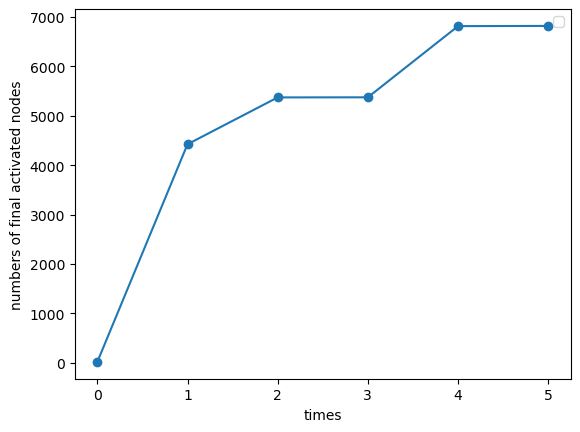

In [101]:

plt.plot(np.arange(len(times)), times, marker='o')
plt.legend()
plt.xlabel("times")
plt.ylabel("numbers of final activated nodes")
plt.show()